In [ ]:
import pygmt
import numpy as np
import pandas as pd
import src.preprocessing as pp
from pygmt.datasets import load_earth_relief
#from geopy.distance import geodesic
#seisblast_codes = '/home/bmelo/bin/SeisBlast/codes'

pygmt.config(#FONT="12p,Palatino-Roman", 
             FONT_ANNOT_PRIMARY="14p,Palatino-Roman",
             FONT_ANNOT_SECONDARY="14p,Palatino-Roman",
             FONT_LABEL="16p,Times-Roman",
             IO_SEGMENT_MARKER="<<<",
             MAP_FRAME_TYPE = 'plain')
#

In [6]:
region = [-10.5, -5, 51.5, 55.5]
seisblast_files = '/home/bmelo/Quarry/Quarry-Blast/tomo/'

# Load station data to lon lat file and dataframe
quarries_james = pd.read_csv(
    seisblast_files + 'lists/IRELAND.quarry.coords.txt',
    sep = r'\s+',
    header=None,
    names=['name','co','lat','lon'])

quarries_james['z']=1

blasts_catalogue = pd.read_csv(
    seisblast_files + 'catalogues/quarry-blast-catalog-all.csv',
    sep=r'\s+',
    header=None,
    names=['ID','date','time','lat','lat-err','lon','lon-err','depth','rms','az','n','magnitude'])

stations = pd.read_csv(
    seisblast_files + 'lists/Total_Stations_List.txt', 
    delimiter=' ',
    names=['sta', 'name','lat', 'lon', 'elevation', 'net', 'end'])

**Function to prepare and select the blast catalogue data per quarry**

In [ ]:
# def haversine_km(lat1, lon1, lat2, lon2):
#     R = 6371.0  # Earth radius in km
#     lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
#     return 2 * R * np.arcsin(np.sqrt(a))

# def quarry_select(quarry_locations_df, blast_catalogue_df, radius):
#     """
#     Relocate blasts using GMT select based on quarry locations and a specified radius.
#     Parameters:
#     quarry_locations_df (pd.DataFrame): DataFrame containing quarry locations with columns 'lat' and 'lon'.
#     blast_catalogue_df (pd.DataFrame): DataFrame containing blast events with columns 'LON(deg)', 'LAT(deg)', and 'EVENT-ID'.
#     radius (str): Radius for selection in GMT format (e.g., '10k' for 10 kilometers).
#     Returns:
#     tuple: A tuple containing:
#         - relocated_blasts (pd.DataFrame): DataFrame of relocated blasts with columns 'lon_ev', 'lat_ev', 'id-ev', 'lon-quarry', 'lat-quarry'.
#         - remain_blasts (pd.DataFrame): DataFrame of remaining blasts that were not relocated.
#         - repeated_blasts (pd.DataFrame): DataFrame of blasts that were assigned to more than one quarry location.
#     """

#     relocated_blasts = pd.DataFrame()
#     repeated_blasts = pd.DataFrame()
#     result = pd.DataFrame()
    
#     #convert the blast catalogue dataframe to lon, lat (ASCII) to load into gmt select
#     blast_catalogue_df.to_csv(f'{seisblast_files}/Eire_blasts.gmt', 
#             columns=['lon','lat','ID'], 
#             sep="\t", 
#             header=False, 
#             index=False)

#     for index, row in quarry_locations_df.iterrows():
#         quarry_lat = quarry_locations_df.loc[index, "lat"]
#         quarry_lon = quarry_locations_df.loc[index, "lon"]
#         quarry_loc = str(quarry_lon) + "/" + str(quarry_lat)

#         result = pygmt.select(
#             data=f'{seisblast_files}/Eire_blasts.gmt',
#             output_type="pandas",
#             dist2pt=quarry_loc + "+d" + radius,
#             region=region,
#         )

#         if not result.empty:
#             result.columns = ['lon', 'lat', 'ID']
#             result["new-lon"] = quarry_lon
#             result["new-lat"] = quarry_lat
#             result["dist"] = haversine_km(
#                     result["lat"], result["lon"], quarry_lat, quarry_lon
#                 )
#             relocated_blasts = pd.concat([relocated_blasts, result], ignore_index=True)

#     if not relocated_blasts.empty:
#         relocated_blasts.columns = [
#             "lon_ev",
#             "lat_ev",
#             "id-ev",
#             "lon-quarry",
#             "lat-quarry",
#             "dist (km)"
#         ]
    
#         # Filter values that appear more than once
#         value_counts = relocated_blasts['id-ev'].value_counts()
#         repeated_values = value_counts[value_counts > 1]
        
#         # Check if there are no repeated values
#         if not repeated_values.any():
#             print('    ~~~the selection radius '+str(radius)+' found ' +str(relocated_blasts.shape[0])+' matches and no double assigments.')
#         else: 
#             # If there are repeated values, print the number of non-unique assignments
#             print('    ~~~the selection radius '+str(radius)+' found ' +str(relocated_blasts.shape[0])+' matches and '+str(repeated_values.iloc[0].max())+' non-unique assigments.')
#             repeated_blasts = relocated_blasts[relocated_blasts['id-ev'].isin(repeated_values.index)]
#             relocated_blasts = relocated_blasts[~relocated_blasts['id-ev'].isin(repeated_values.index)]
        
#         # Build new event list with the remaining blasts
#         remain_blasts = blast_catalogue_df[~blast_catalogue_df['ID'].isin(relocated_blasts["id-ev"])]
#         print("    ~~~out of "+str(blast_catalogue_df.shape[0])+" initial events, "+str(remain_blasts.shape[0])+" quarry blast events remain")
#     else:
#         # If no matches were found
#         print('    ~~~the selection radius '+str(radius)+' found no matches.')
        
#     return relocated_blasts, remain_blasts, repeated_blasts

**Load station,  quarry data**

**Loop from smaller radius search to a maximum of ~8km and save results to files**


In [ ]:
#kind of empirically tested radius values to select the quarry blasts without double assigments
#by double assigments we mean that the same blast is assigned to more than one quarry
#from 0.5 to 5 km search in ~100m steps
radius = np.concatenate((np.linspace(0.005, 0.0095, 10), 
						 np.linspace(0.01, 0.05, 25)))

# Initialize relocated_blasts_all
relocated_blasts_all = pd.DataFrame()
doubles_all = pd.DataFrame()

remain_blasts_catalogue = blasts_catalogue

for r in radius:
    print(" ")
    print(" >>processing radius "+str(r))
    quarry_blasts, remain_blasts_catalogue, doubles = pp.quarry_select(region, quarries_james, remain_blasts_catalogue, str(r), seisblast_files + 'seisblast/')
    relocated_blasts_all = pd.concat([relocated_blasts_all, quarry_blasts], ignore_index=True)
    doubles_all = pd.concat([doubles_all, doubles], ignore_index=True)
    
#Check double assignments
unique_id_ev_count = doubles_all['id-ev'].nunique()
print(f" >>number of doubles': {unique_id_ev_count}")
doubles_filter = doubles_all.drop_duplicates().sort_values(by='id-ev')

doubles_filter.to_csv(f'{seisblast_files}/Eire_blasts_all-toreview.csv', index=False)
remain_blasts_catalogue.to_csv(f'{seisblast_files}/Eire_blasts_all-lost.csv', index=False)
relocated_blasts_all.to_csv(f'{seisblast_files}/Eire_blasts_all-relocated.csv', index=False)

 
 >>processing radius 0.005
    ~~~the selection radius 0.005 found 266 matches and 2 non-unique assigments.
    ~~~out of 5636 initial events, 5372 quarry blast events remain
 
 >>processing radius 0.0055
    ~~~the selection radius 0.0055 found 75 matches and 2 non-unique assigments.
    ~~~out of 5372 initial events, 5299 quarry blast events remain
 
 >>processing radius 0.006
    ~~~the selection radius 0.006 found 53 matches and 2 non-unique assigments.
    ~~~out of 5299 initial events, 5248 quarry blast events remain
 
 >>processing radius 0.006500000000000001
    ~~~the selection radius 0.006500000000000001 found 54 matches and 2 non-unique assigments.
    ~~~out of 5248 initial events, 5196 quarry blast events remain
 
 >>processing radius 0.007
    ~~~the selection radius 0.007 found 66 matches and 2 non-unique assigments.
    ~~~out of 5196 initial events, 5138 quarry blast events remain
 
 >>processing radius 0.0075
    ~~~the selection radius 0.0075 found 68 matches and 2

pygmt-session [WARNING]: Unable to parse 1 longitude strings
pygmt-session [WARNING]: Unable to parse 1 longitude strings
pygmt-session [WARNING]: Unable to parse 1 longitude strings
pygmt-session [WARNING]: Unable to parse 1 longitude strings


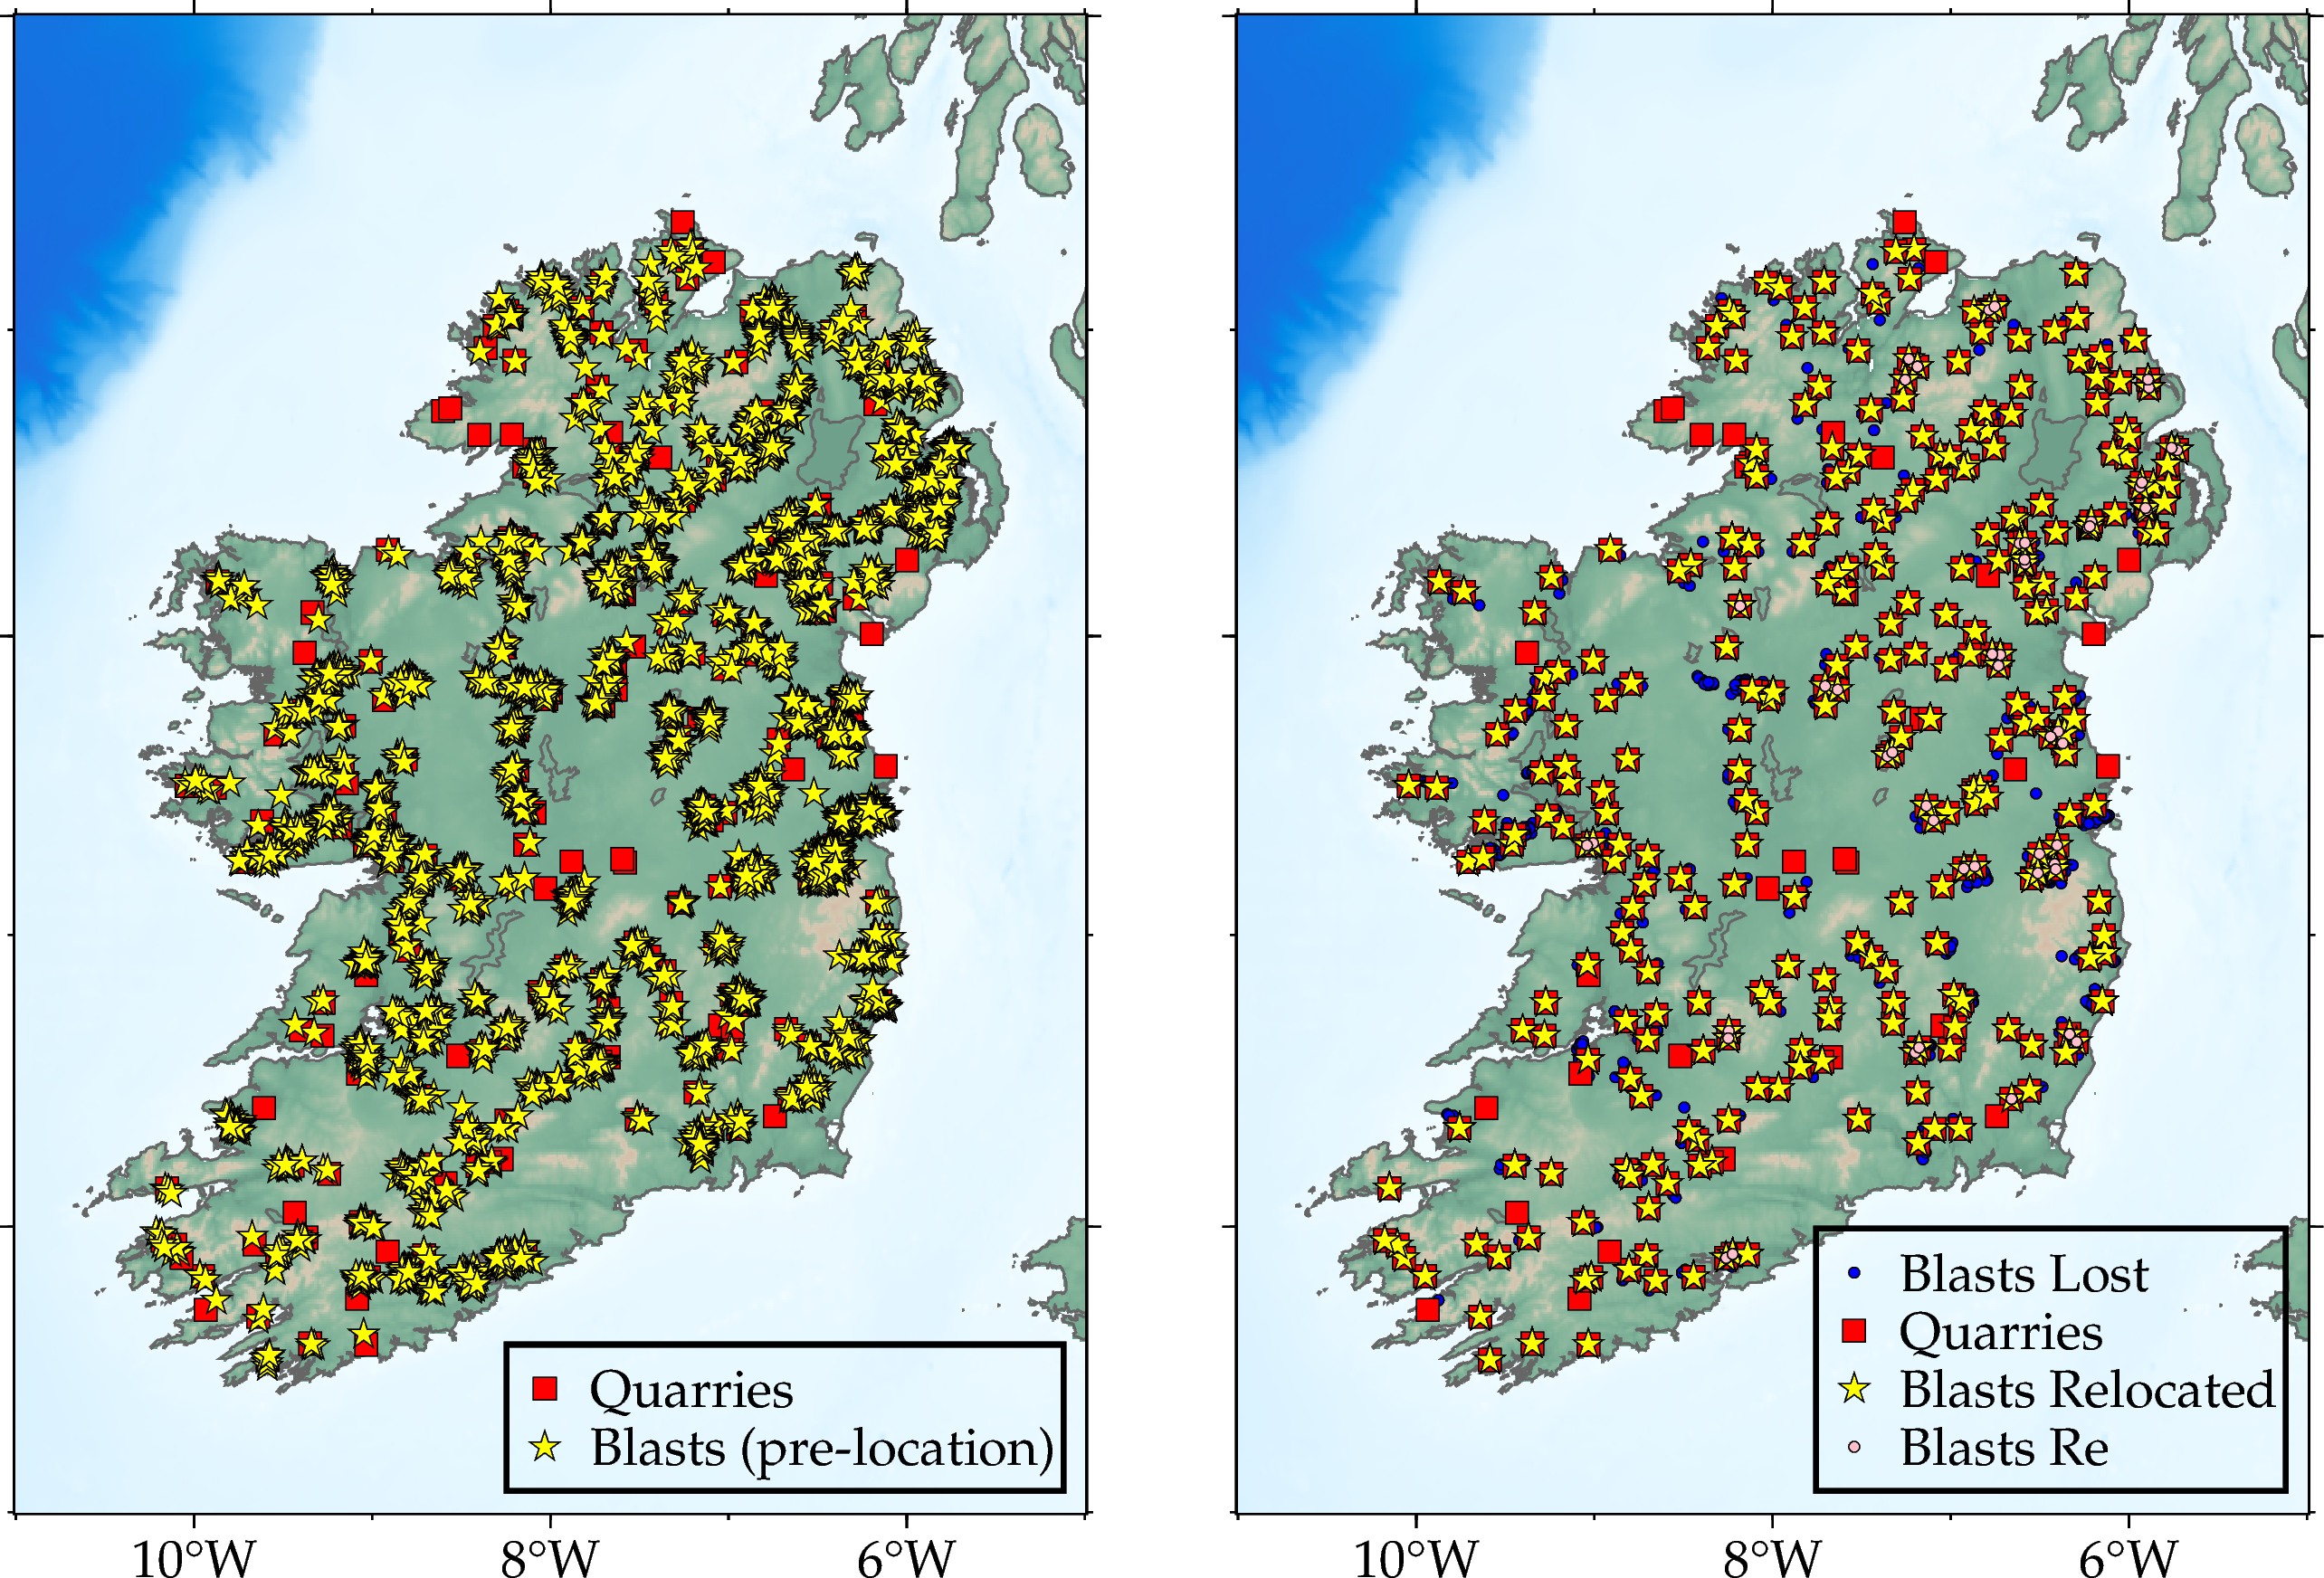

In [ ]:
blasts = pd.read_csv(seisblast_files + 'seisblast/Eire_blasts_all-relocated.csv')
noblasts = pd.read_csv(seisblast_files + 'seisblast/Eire_blasts_all-lost.csv')
reblasts = pd.read_csv(seisblast_files + 'seisblast/Eire_blasts_all-toreview.csv')

region = [-11, -5, 51, 56]

topo = load_earth_relief(
    resolution="30s",
    region=region,
    registration="gridline",
)

fig = pygmt.Figure()

with fig.subplot(
    nrows=1,
    ncols=3,
    figsize=("33c", "14c"),
    frame="wesn",
    margins="0.5/1c",
    sharex="b",
    sharey="r"
    #autolabel=True
    ):
    
    pygmt.makecpt(cmap="terra", series=[-5000, 3000])
    with fig.set_panel(panel=0):
        fig.basemap(region=region, projection="M?")
        fig.grdimage(grid=topo)
        fig.coast(shorelines="0.6p,gray40", resolution="h")#, water="lightblue")
        #fig.plot(x=stations['lon'], y=stations['lat'], style="t0.4c", pen="black", fill="orange", label="Stations")
        fig.plot(x=quarries_james['lon'], y=quarries_james['lat'], style="s0.3c", fill="red", pen="black", label="Quarries")
        fig.plot(x=blasts_catalogue['lon'], y=blasts_catalogue['lat'], style="a0.3c", fill="yellow", pen="black", label="Blasts (pre-location)")
        fig.legend(position="jBR+o0.2c", box=True)
        
    with fig.set_panel(panel=1):
        fig.basemap(region=region, projection="M?")
        fig.grdimage(grid=topo)
        fig.coast(shorelines="0.6p,gray40", resolution="h")#, water="lightblue")
        #fig.plot(x=stations['lon'], y=stations['lat'], style="t0.4c", pen="black", fill="orange", label="Stations")
       
        fig.plot(x=noblasts['lon'], y=noblasts['lat'], style="c0.1c", fill="blue", pen="black", label="Blasts Lost")
        fig.plot(x=quarries_james['lon'], y=quarries_james['lat'], style="s0.3c", fill="red", pen="black", label="Quarries")
        fig.plot(x=blasts['lon-quarry'], y=blasts['lat-quarry'], style="a0.3c", fill="yellow", pen="black", label="Blasts Relocated")
        fig.plot(x=reblasts['lon-quarry'], y=reblasts['lat-quarry'], style="c0.1c", fill="pink", pen="black", label="Blasts Re")
        fig.legend(position="jBR+o0.2c", box=True)
        
    # with fig.set_panel(panel=2):
    #         # Plot the grid
    #     fig.basemap(region=region, projection="M?")
    #     pygmt.makecpt(cmap="SCM/lisbon", series=[0,150], background=False, reverse=False)
    #     fig.grdimage(grid=masked_grid, region=region,frame=["WSne"])
    #     fig.coast(shorelines=True, borders=1, resolution="h")
        #ax.plot(x=all_lons, y=all_lats, transparency=30, pen="0.1p,black")
        # fig.plot(x=ray_info['quarry_lon'], y=ray_info['quarry_lat'], style="s0.2c", fill="red", pen="0.1p", label="Quarries")
        # fig.plot(x=ray_info['station_lon'], y=ray_info['station_lat'], style="t0.3c", fill="orange", pen="0.1p", label="Stations")
        # fig.colorbar(frame = ["a50f10","x+l#Raypaths"], position = "jBR+w5c/0.3c+h+o0.5/0.8")
        # fig.text(x=-7.5, y=51.5, text="max:"+str(density.max()))#, font="10p,Helvetica,black")
    #add a subplot with the ray paths


# Add legend
fig.show(width=800)
fig.savefig(seisblast_files + "seisblast/blasts_relocation.png", dpi=300)

**Plot results with PyGMT**